# Preliminaries
###### Let me start by: 
     (1)Importing the modules I need
     (2)Loading up and preparing the data I need
     (3)Plotting the data using Matplotlib's defaults

In [2]:
%matplotlib inline
import matplotlib.pyplot as p
import numpy as n
from pandas import read_csv

In [3]:
data = read_csv('Data.csv').values
d0,d90,d45 = (data[:,[2*i,2*i+1]] for i in range(3))
d0 = d0[ d0[:,0]<=.08, :]
d45 = d45[ d45[:,0]<=.08, :]
d90 = d90[ d90[:,0]<=.08, :]

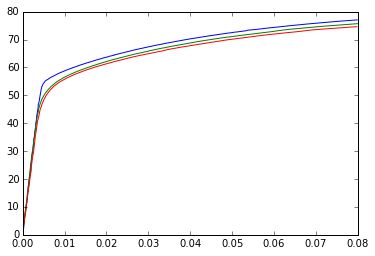

In [5]:
p.plot(d0[:,0],d0[:,1],d45[:,0],d45[:,1],d90[:,0],d90[:,1])

# Walkthrough
Let's pick a Dr. K figure and see if we can duplicate it.

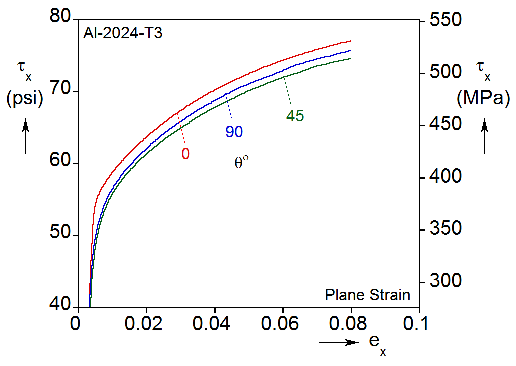

In [6]:
from IPython.display import Image
Image(filename='Goal.png') 

##### A few observations:
    (1) An axes linewidth that is surely greater than the MPL default
    (2) Ticks are out and off on the top
    (3) Arial font for English characters, but Times New Roman font for Greek
    (4) These arrows on the axis labels
    (5) Rotated y-axis labels, with units below the quantity
    (6) Two *different* y-scales!
    (7) No legend, but colored connectors to each line with it's respective label
    (8) Text annotations within the axes characters

###### So let's see how close we can get.

# The first thing we'll do is call a mpl stylesheet I made
###### This will take care of observations (1), (2), and (3), except for turning off the ticks on top.
A critical setting from this stylesheet is setting `'mathtext.fontset : stix'`, and `'mathtext.default : rm'`.  `Stix` and `rm` were the only combination of settings that I found to easily give us the flexibility needed to satisfy observation (3), while also *consistently* working on various different MPL versions and installations (i.e., Windows and Ubuntu).
Note that the style sheet also calls `'font.sans-serif : Arial'`.  If Arial is unavailable, Liberation Sans is a good alternative common on Linux distributions.

In [7]:
p.style.use('mysty')

Let's see how a plot looks doing this

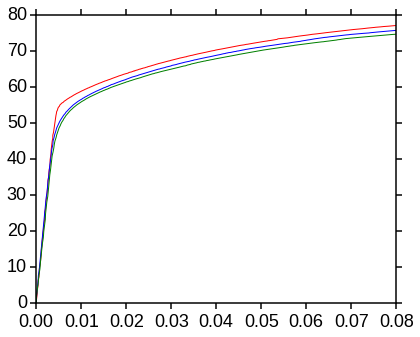

In [10]:
p.plot(d0[:,0],d0[:,1],d45[:,0],d45[:,1],d90[:,0],d90[:,1])

Certainly better than the MPL defaults.  But we need a little more help.  Here's the biggest part of this package.

# `import figfun`

`figfun` contains the function `myax()` to which we'll pass our figure
for formatting.  It will take care of observations (4), (5), and (6).  It is fairly-well comented, so if you have a good understanding of how MPL works you should understand what does what.


Admittedly I don't understand just what is so special about `bounding boxes`, why they require special handling, and why methods used to extract the info I need from them varies depending on what its parent object is (i.e. the axis frame, or the tick labels, or the axis labels).   Furthermore, their behaviour is *not* well described in the MPL documentation, IMO.  So a lot of this I figured out by working in Jupyter and using the `tab` completion to see what methods were available.

Also within figun is a patch `MyArrow`, which is defined as a polygon subclass.  It is a hack of the matplotlib FancyArrow, which I discovered had some problems when saving as PDFs.  I also found its behavior to be strange and unintuitive...I'll get around to raising an issue on the MPL github page one of these days.<br>
Finally, there are some little functions in there to help do some things like transform from data to axes coordinates without fighting through the cumbersome `ax.transform` syntax.

In [11]:
import figfun as f

<font size = 3> All we need to do is plot our data, define the axis labels, then pass the figure to the function f.myax().<br>Be sure to define the labels ***before*** calling `myax().`</font><br>  I'll also set our axis limits so that they're identical to the goal figure.

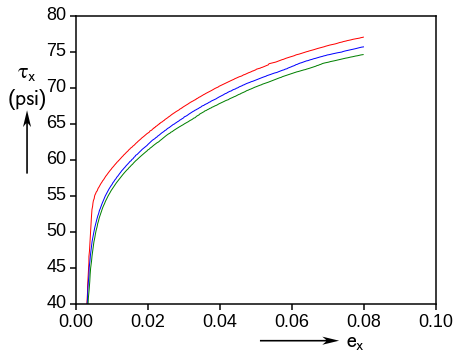

In [12]:
p.plot(d0[:,0],d0[:,1],d45[:,0],d45[:,1],d90[:,0],d90[:,1])
p.axis([0,.1,40,80])
p.xlabel('$\\mathsf{e}_{\\mathsf{x}}$')
p.ylabel('$\\tau_{\\mathsf{x}}$\n($\\mathsf{psi}$)')
f.myax( p.gcf() )

So with some careful use of mathtext on the axis labels, and one line of code in which we pass our figure through `myax()`, we get a figure back that is quite close to our goal.  Notice that, by default, the function removes the ticks on the right and top.

Let's do it again, but this time add the right axis label.  To do this we'll pass an axis-units conversion fucntion as the second argument to `myax()`.  Ksi-to-Mpa is need so often that I defined a conversion function within `figfun`. We'll also define the right axis label and pass that in as the third argument.

Again I'll have to specif the axis range, and I'll also specify the ticks.

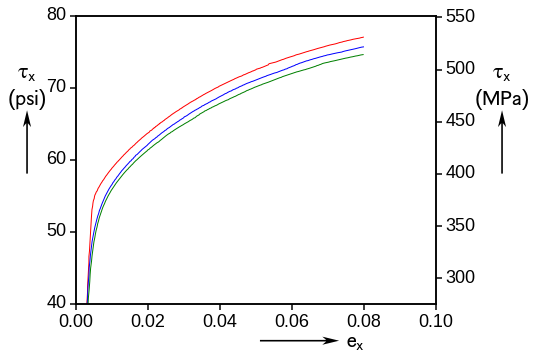

In [13]:
p.plot(d0[:,0],d0[:,1],d45[:,0],d45[:,1],d90[:,0],d90[:,1])
p.axis([0,.1,40,80])
p.yticks([40,50,60,70,80])
p.xlabel('$\\mathsf{e}_{\\mathsf{x}}$')
p.ylabel('$\\tau_{\\mathsf{x}}$\n($\\mathsf{psi}$)')
rightaxlabel = '$\\tau_{\\mathsf{x}}$\n($\\mathsf{MPa}$)'
f.myax( p.gcf(), f.ksi2Mpa, rightaxlabel )

#  We're in business!

Again,  with careful use of mathext and just passing our figure through `myax()` along with the right axis scale and label, we get 90% of the way there!

Before finishing up witht annotations, which unfortunately I cannot automate, let's talk a little more about `myax()`.

In [15]:
print(f.myax.__doc__)


    Converts a figure with to K style.
    Requires figure hande or p.gcf()
    Optional args are unit conversion on label if doing a second right ax,
    then properties for the axis arrows.  These numbers are in Axes Coordinates.
    AL(=.22) is arrow length, including the head
    HL(=.045) is head length.
    HW(=.5) is head width as fraction of the head length!
    OH(=2.9) is overhang as fraction of head length!
    TW(=.0045) is tail width (in absolute axes values)
    PLW(=0) is the patch **kwarg linewidth
    Args for arrow patch pertain to the y-axis arrow, and are scaled acoordingly for the x-axis.
    The defaults are meant to optimize the appearance of the y-axis arrow.
    If conversion and rightaxlabel are both not none, then the twinx() method is used to create a right ax
     


###### You see that all possible arguments have a keyword, and most of them are parameters for the axis arrows (instances of `MyArrow`).  Here are some other important notes:
--If you pass a figure throuh `f.myax()` a second time, all instances of `MyArrow` on the figure will be removed and redrawn.  This is so that you can change the arrow properties if you want to without having to replot the whole figure every time.  However, this feature gets messed up if a right axis scale and label are drawn.

--I highly advise setting you axis limits and ticks as you like prior to calling `myax()`.

--Arrow properties are specified in *axes coordinates*.

# Finishing up
Let's go ahead and add the annotations.  I'll do this with `p.text()`, `p.annotate()`, and `p.ginput()`.  Also, to help with the annotations, I'll get handles for the lines when I call `p.plot()`.

Note I can't use `p.ginput()` with the inline backend, so I'll be loading up a file with the annotation locations stored in them.  Normally, though, if running from a script or using an interactive backend you can just click for whatever you need.

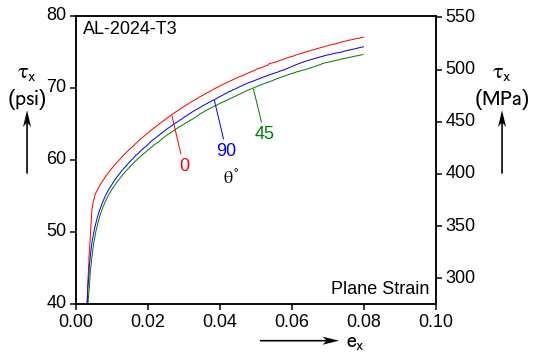

In [100]:
# Everything we did before:
L = p.plot(d0[:,0],d0[:,1],d45[:,0],d45[:,1],d90[:,0],d90[:,1])
p.axis([0,.1,40,80])
p.yticks([40,50,60,70,80])
p.xlabel('$\\mathsf{e}_{\\mathsf{x}}$')
p.ylabel('$\\tau_{\\mathsf{x}}$\n($\\mathsf{psi}$)')
rightaxlabel = '$\\tau_{\\mathsf{x}}$\n($\\mathsf{MPa}$)'
#locs = p.ginput(7)
locs = read_csv('Locs.dat',header=None).values

# Now some new stuff:
p.text(.02,.98,'AL-2024-T3',transform=p.gca().transAxes,ha='left',va='top')
p.text(.98,.02,'Plane Strain',transform=p.gca().transAxes,ha='right',va='bottom')
labels = ['0','90','45']
for i in range(len(L)):
    #locs = n.asarray(p.ginput(2))
    p.annotate('{}'.format(labels[i]),xy=locs[2*i],xytext=locs[2*i+1],
               color=L[i].get_color(),ha='center',va='top',
               arrowprops=dict(arrowstyle='-', color=L[i].get_color()) )
p.text(locs[-1,0],locs[-1,1],'$\\theta^{\\circ}$')
    
f.myax( p.gcf(), f.ksi2Mpa, rightaxlabel )
p.savefig('OurFig.png',bbox_inches='tight',dpi=100)

# That's it!
I think we did pretty damn good.  Maybe the various fontsizes need tweaking, and the arrow might meed to be a bit less bold...I'm not sure.  But I can say this:  I showed this figure to Dr. K and he thought it was the Kaleidagraph version.  So I call that a win.

For good measure, let's go ahead and show them side-by-side.</font>

(-0.5, 743.5, 498.5, -0.5)

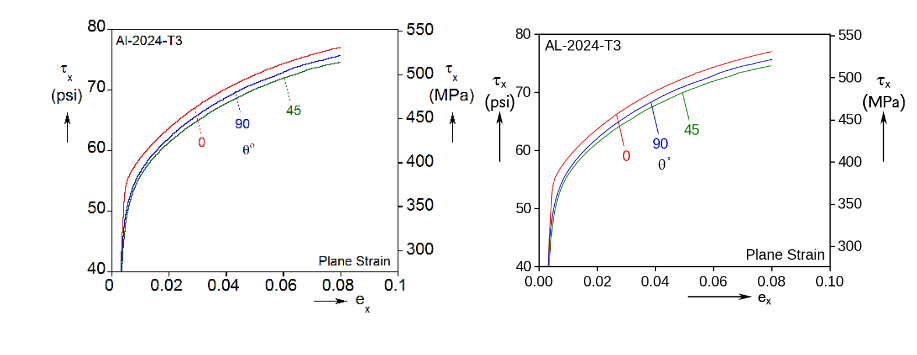

In [101]:
fig = p.figure(figsize=(12,6))
ax1 = fig.add_axes([0,0,.5,1])
goal = p.imread('Goal.png')
ax1.imshow(goal)
ax1.axis('image')
ax1.axis('off')
ax2 = fig.add_axes([.5,0,.5,1])
ours = p.imread('OurFig.png')
ax2.imshow(ours)
ax2.axis('image')
ax2.axis('off')

Note that this plot of Dr. K's has unusually short axis arrows.   I didn't bother changing from the `myax()` defaults but we definitely could.

### Just ignore all this stuff below. I needed these to get the annotation locations.
Also I changed the linewidth and color cycle from what is set in the 'mysty' rcfile to make it syntactically easier to make this one particular figure.

In [ ]:
%matplotlib 
p.style.use('mysty')
p.rcParams['axes.color_cycle'] = ('r','b','g')
p.rcParams['lines.linewidth'] = 1
# Everything we did before:
L = p.plot(d0[:,0],d0[:,1],d45[:,0],d45[:,1],d90[:,0],d90[:,1])
p.axis([0,.1,40,80])
p.yticks([40,50,60,70,80])
p.xlabel('$\\mathsf{e}_{\\mathsf{x}}$')
p.ylabel('$\\tau_{\\mathsf{x}}$\n($\\mathsf{psi}$)')
rightaxlabel = '$\\tau_{\\mathsf{x}}$\n($\\mathsf{MPa}$)'
locs = n.asarray(p.ginput(7))

In [82]:
n.savetxt('Locs.dat',X=locs,delimiter=',')

In [96]:
%matplotlib inline
p.style.use('mysty')
p.rcParams['axes.color_cycle'] = ('r','b','g')
p.rcParams['lines.linewidth'] = 1

In [9]:
p.rcParams['axes.color_cycle'] = ('r','b','g')
p.rcParams['lines.linewidth'] = 1